Recently a couple of customers have asked questions along the lines of: "How do I do an R-group decomposition and then recombine the cores and R groups to create new molecules?" That's an interesting and useful task which the RDKit has some built-in tools to help with, so I figured I'd do a blog post.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdqueries
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdDepictor
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
import itertools
import rdkit
print(rdkit.__version__)

2022.03.1pre


Note: Though I'm doing this blog post using a local build from RDKit master all of the functionality which I demonstrate here is already available in the 2021.09 release series.

# Read in the dataset

Read in a bunch of molecules from a J Med Chem paper (https://doi.org/10.1021/acs.jmedchem.7b00306 the paper is open access). Here I downloaded the SMILES in the supporting information, sketched the scaffold manually, and then saved the scaffold + molecules to an SD file. The scaffold is the first molecule in the SDF.

There are 31 molecules


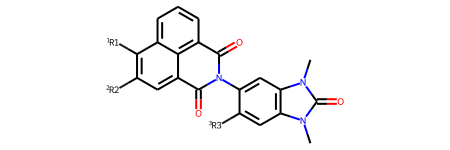

In [2]:
ms = [mol for mol in Chem.SDMolSupplier('../data/jm7b00306.sdf')]
core = ms[0]
ms.pop(0)
print(f'There are {len(ms)} molecules')
core

Now let's look at some of the other molecules

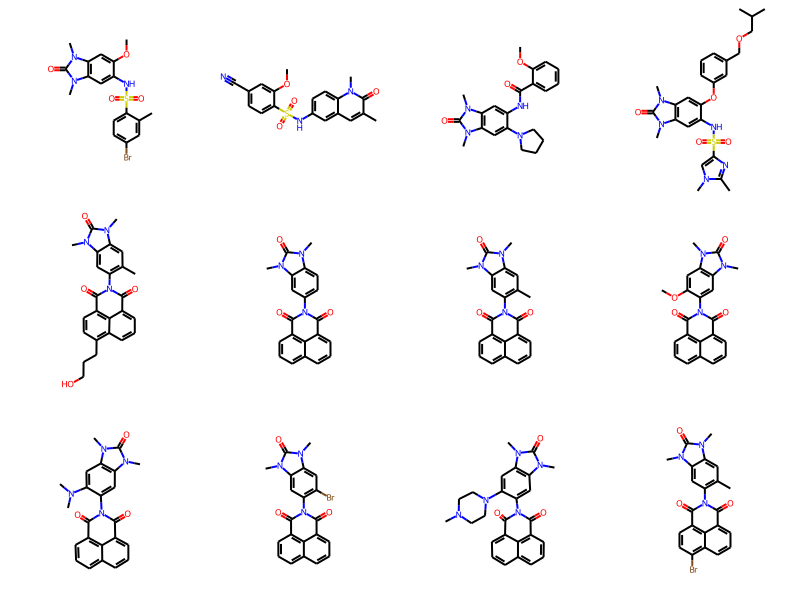

In [3]:
Draw.MolsToGridImage(ms[:12],molsPerRow=4)

# Doing the R-group decomposition

The RGD code takes a list of cores to be used along with a list of molecules. It returns a 2-tuple with:
1. a dictionary with the results
2. a list with the indices of the molecules which failed; these are molecules which did not match any of the cores

I've blogged about the RGD code before [here](http://rdkit.blogspot.com/2019/12/using-r-group-decomposition-code.html) and [here](https://greglandrum.github.io/rdkit-blog/tutorial/prototypes/drawing/2021/08/07/rgd-and-highlighting.html) if you want to read more about it. It's probably time for another post with an update, but those are hopefully already useful.

In [4]:
rgd,failed = rdRGroupDecomposition.RGroupDecompose([core],ms,asRows=False)
len(failed)

6

In [5]:
failed

[0, 1, 2, 3, 29, 30]

In [6]:
rgd.keys()

dict_keys(['Core', 'R1', 'R2', 'R3'])

Let's look at the results

There are 25 R1s


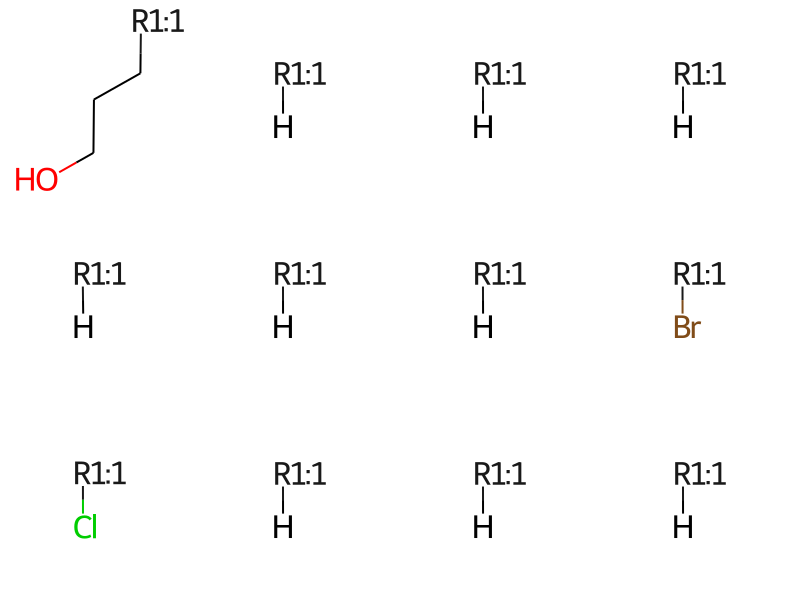

In [7]:
print(f'There are {len(rgd["R1"])} R1s')
Draw.MolsToGridImage(rgd['R1'][:12],molsPerRow=4)

Remove any R groups which have more than one dummy atom. This happens if an R group is attached to the core at multiple points and it may mess up the rest of the analysis.

In [8]:
qa = rdqueries.AtomNumEqualsQueryAtom(0)
r1 = [x for x in rgd['R1'] if len(x.GetAtomsMatchingQuery(qa))==1]
r2 = [x for x in rgd['R2'] if len(x.GetAtomsMatchingQuery(qa))==1]
r3 = [x for x in rgd['R3'] if len(x.GetAtomsMatchingQuery(qa))==1]

Now find the unique members in each set of R groups:

In [9]:
def uniquify(rgs):
    seen = set()
    keep = []
    for rg in rgs:
        smi = Chem.MolToSmiles(rg)
        if smi not in seen:
            keep.append(rg)
            seen.add(smi)
    return keep

In [10]:
r1s = uniquify(r1)
r2s = uniquify(r2)
r3s= uniquify(r3)
print(len(r1s),len(r2s),len(r3s))

15 6 6


Look at the unique R1s:

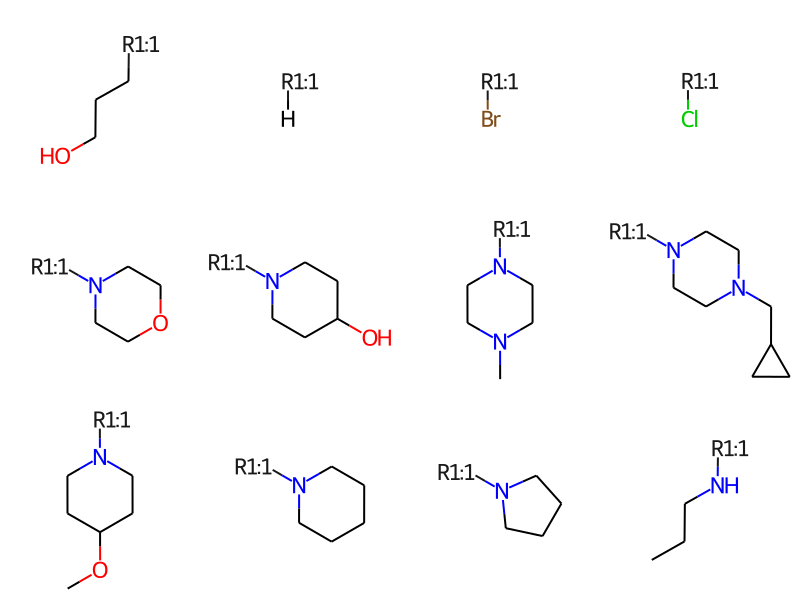

In [11]:
Draw.MolsToGridImage(r1s[:12],molsPerRow=4)

# Enumerating all possible molecules from the R groups

## Quick intro to molzip

We'll use the RDKit's `molzip()` function to recombine the cores with the side chains. 

`molzip` lets you take a molecule containing multiple fragments and "zip" them together. The atoms which should be bonded in the final molecule are labelled by connecting them to dummy atoms. The code identifies matching dummy atoms (by default this means dummies with the same isotopic label) in the fragments, adds bonds between the atoms connected to the dummies, and then removes the dummies.

Here's a simple example using a molecule with three fragments:

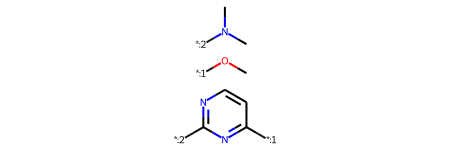

In [12]:
sample = Chem.MolFromSmiles('[*:1]c1nc([*:2])ncc1.CO[*:1].[*:2]N(C)C')
sample

And this is what happens when we zip those together:

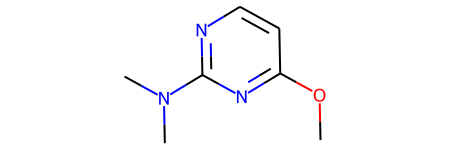

In [13]:
Chem.molzip(sample)

### Using molzip with RGD output

The molzip function is perfect for working with the output from an R-group decomposition.

Here I'll define the function we're going to use to enumerate all of the products:

In [14]:
import random
def enumerate_all_products(core,*rgroups,randomOrder=False):
    # preserve the positions of the non-dummy core atoms, 
    # we will use these to make sure the cores are drawn
    # the same way in each molecule we generate
    corePos = {}
    conf = core.GetConformer()
    for i in range(conf.GetNumAtoms()):
        corePos[i] = Geometry.Point2D(conf.GetAtomPosition(i))
        
    # Python's itertools handles doing the combinatorics of generating
    # every possible combination of R groups:
    order = itertools.product(*rgroups)
    if randomOrder:
        order = list(order)
        random.shuffle(order)
        
    # now we just loop over each combination, copy all the pieces into
    # one molecule, and zip it. That's our product
    for tpl in order:
        tm = Chem.RWMol(core)
        for r in tpl:
            tm.InsertMol(r)
        prod = Chem.molzip(tm)
        if prod is not None:
            # generate 2d coordinates with the core fixed in place
            rdDepictor.Compute2DCoords(prod,canonOrient=False,coordMap=corePos)
            
            # and finally yield the product molecule
            yield prod

We're going to use the core which came from the RGD since it's labelled in the same way as the sidechains

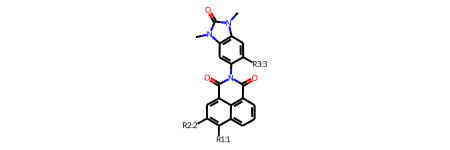

In [15]:
rgd_core = rgd['Core'][0]
rgd_core

Let's try it out:

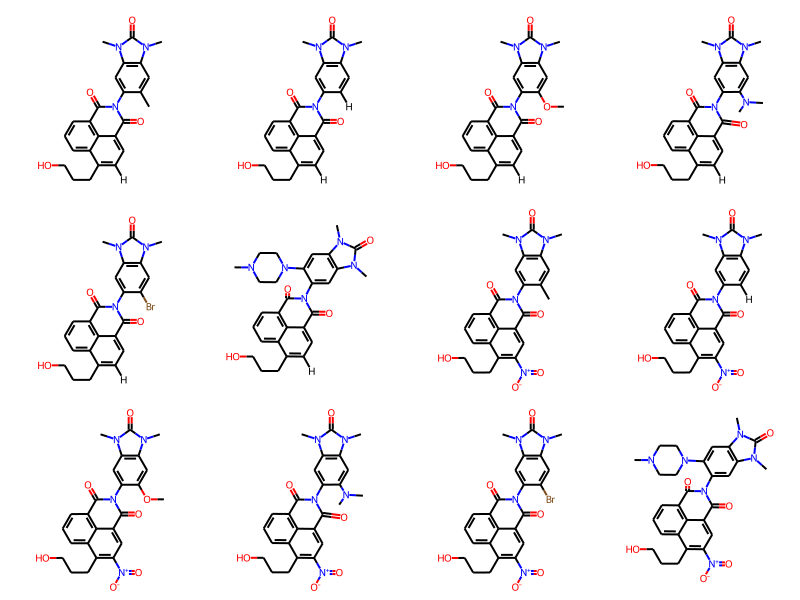

In [16]:
# this returns a generator which produces products:
prod_gen = enumerate_all_products(rgd_core,r1s,r2s,r3s)

# now get the first unique products 
prods = []
seen = set()
for prod in prod_gen:
    if prod is not None:
        Chem.SanitizeMol(prod)
        smi = Chem.MolToSmiles(prod)
        if smi not in seen:
            prods.append(prod)
            seen.add(smi)
        if len(prods)>=12:
            break
Draw.MolsToGridImage(prods,molsPerRow=4)

Those come back ordered by the R groups (i.e. all products created using the first value of R1, then all products created using the second value of R1, etc.). This is fine if we're planning on enumerating all the molecules, but if we only need a subset we can tell `enumerate_all_products()` to return the results in a random order:

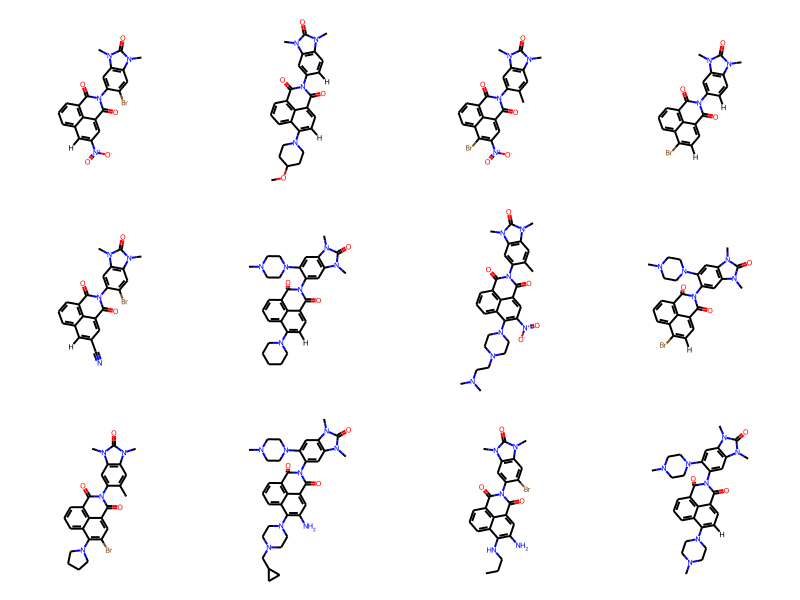

In [17]:
# set a random seed so that we get reproducible results
random.seed(0xbaff7ed)
prod_gen = enumerate_all_products(rgd_core,r1s,r2s,r3s,randomOrder=True)
prods = []
seen = set()
for prod in prod_gen:
    if prod is not None:
        Chem.SanitizeMol(prod)
        smi = Chem.MolToSmiles(prod)
        if smi not in seen:
            prods.append(prod)
            seen.add(smi)
        if len(prods)>=12:
            break
Draw.MolsToGridImage(prods,molsPerRow=4)

Hopefully this brief post is useful!